In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_validation import KFold

In [53]:
train = pd.read_csv('../../train.csv').ix[:,1:]
testSet = pd.read_csv('../../test.csv').ix[:,1:]

In [54]:
# encode features for random forest and concatenate them back to dataframe
train = pd.concat([train, train['season'].str.get_dummies(sep=',')], axis=1)
train = pd.concat([train, train['dayOfWeek'].str.get_dummies(sep=',')], axis=1)

testSet = pd.concat([testSet, testSet['season'].str.get_dummies(sep=',')], axis=1)
testSet = pd.concat([testSet, testSet['dayOfWeek'].str.get_dummies(sep=',')], axis=1)

In [55]:
# we don't have 'spring', 'summer', 'fall' in current test set
cols = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 
        'holiday','winter', 'stationID',
        'max', 'min', 'rain' ,'snow']

X_train = train[cols]
y_train = train.visited
X_test = testSet[cols]
y_test = testSet.visited

In [101]:
# random forest regressor

# deterine how many trees to use
rmse = []
r2 = []
numTrees = range(20,150)

for i in numTrees:
    rf = RandomForestRegressor(n_estimators=i)
    rf.fit(X_train, y_train)
    r2.append(r2_score(y_test, rf.predict(X_test)))
    rmse.append(np.sqrt(np.mean((y_test - rf.predict(X_test))**2)))

In [114]:
bestTreeNum = numTrees[np.argmin(rmse)]
# 1 standard deviation rule
std = np.std(rmse)
for i in range(len(rmse)):
    if rmse[i] < min(rmse) + std:
        minTree = numTrees[i]
        minRmse = rmse[i]
        break
print(minTree, minRmse)

70 53.5740947787


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


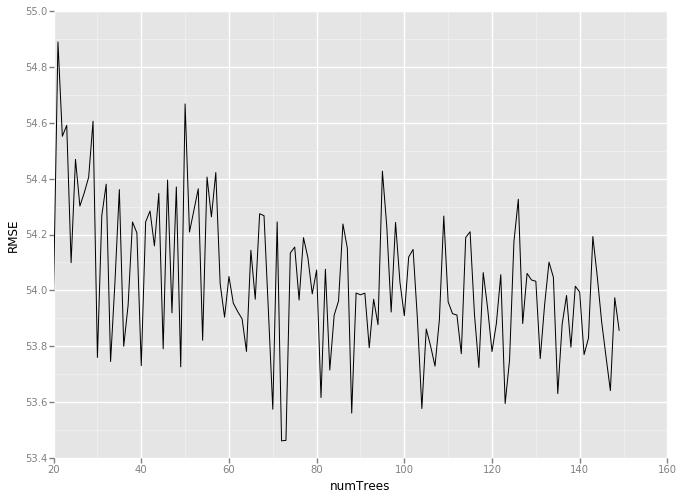

<ggplot: (-9223372036577706019)>

In [102]:
from ggplot import *
%matplotlib inline

scoresRF = pd.DataFrame({
        'numTrees': pd.Series(numTrees),
        'RMSE': pd.Series(rmse),
        'R2': pd.Series(r2)})

ggplot(aes(x='numTrees', y='RMSE'), data=scoresRF) + geom_line() 

In [92]:
# gredient boosting regressor with least square loss function
params = {'n_estimators': 2000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}

# cross-validate to determine how many trees to use
def heldoutScore(gbm, X, y):
    """compute deviance scores on X_test and y_test."""
    scores = np.zeros(params['n_estimators'])
    for i, y_pred in enumerate(gbm.staged_predict(X)):
        scores[i] = gbm.loss_(y, y_pred)
    return scores

def cvGBM(n_folds=5):
    """cross-validation for GBM"""
    cv = KFold(n=X_train.shape[0], n_folds=n_folds)
    gbm = GradientBoostingRegressor(**params)
    loss = np.zeros(params['n_estimators'])
    for train, test in cv:
        gbm.fit(X_train.iloc[train], y_train.iloc[train])
        loss += heldoutScore(gbm, X_train.iloc[test], y_train.iloc[test])
    loss /= n_folds
    return loss

# Estimate best n_estimator using cross-validation
cvScores = cvGBM()

x = np.arange(1, params['n_estimators'] + 1)
cvBestIter = x[np.argmin(cvScores)]

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


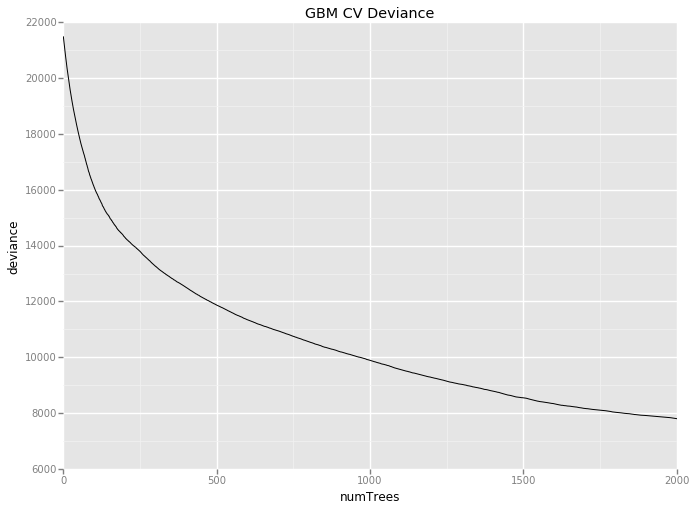

<ggplot: (279683206)>

In [93]:
# plot cv deviance
scoresGbmCV = pd.DataFrame({
            'numTrees': pd.Series(x),
            'deviance': pd.Series(cvScores)})
    
ggplot(aes(x='numTrees', y='deviance'), data=scoresGbmCV) + geom_line() + labs(title='GBM CV Deviance')

In [95]:
# test on test set with cv result
params = {'n_estimators': cvBestIter, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}

gbm = GradientBoostingRegressor(**params)

gbm.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, gbm.predict(X_test)))
print(rmse)

# get stage loss
loss = np.zeros(params['n_estimators'])

for i, pred in enumerate(gbm.staged_predict(X_test)):
    loss[i] = gbm.loss_(y_test, pred)

53.2858846023


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


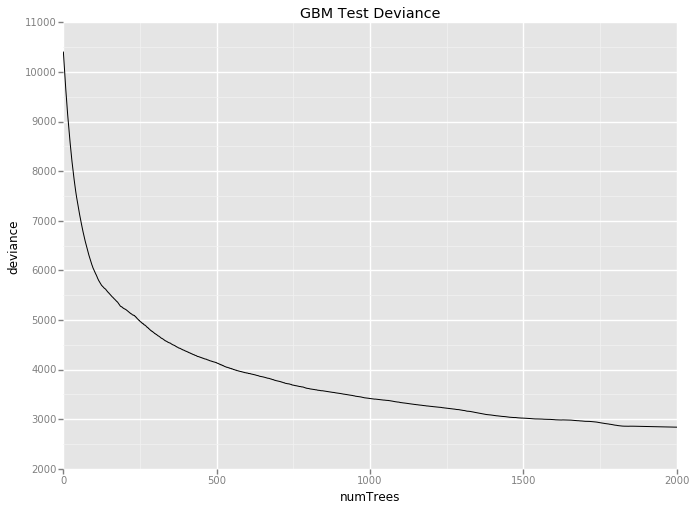

<ggplot: (279695915)>

In [100]:
# plot test deviance
scoresGBM = pd.DataFrame({
            'numTrees': pd.Series(x),
            'deviance': pd.Series(loss)})
    
ggplot(aes(x='numTrees', y='deviance'), data=scoresGBM) + geom_line() + labs(title='GBM Test Deviance')

In [115]:
# write model to pickle for later use
from sklearn.externals import joblib
joblib.dump(gbm, 'gbm.pkl', compress=9)

['gbm.pkl']

In [81]:
# train models for single stations
# 387, 521, 293, 127, 83

# we don't have 'spring', 'summer', 'fall' in current test set
cols = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 
        'holiday','winter', 'stationID',
        'max', 'min', 'rain' ,'snow']

X_train = train[cols]
y_train = train.visited
X_test = testSet[cols]
y_test = testSet.visited

params = {'n_estimators': 1500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}

stationNum = 5
singleModels = [GradientBoostingRegressor(**params) for _ in range(stationNum)]
ids = [387, 521, 293, 127, 83]

for model, id in zip(singleModels, ids):
    model.fit(X_train.loc[X_train['stationID'] == id], y_train.loc[X_train['stationID'] == id])

In [82]:
from sklearn.externals import joblib
joblib.dump(singleModels, 'models/singleGBMs.pkl', compress=9)

['models/singleGBMs.pkl']